# Impact comparison
<!-- markdownlint-disable MD013 -->
Comparison of historical impact from various sources, each of which have their own notebook for basic processing:

- NEMA flood risk
- NiHSA flood record
- UNICEF impact
- IOM impact

Also includes Floodscan exposure.

In [1]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

from src.datasources import codab, floodscan, hydrosheds
from src.utils import blob
from src.constants import *

## Load data

### CODAB

In [3]:
adm1 = codab.load_codab_from_blob(admin_level=1, aoi_only=True)

In [4]:
adm2 = codab.load_codab_from_blob(admin_level=2, aoi_only=True)

### NiHSA flood record

In [13]:
import src.constants

blob_name = f"{src.constants.PROJECT_PREFIX}/processed/nihsa/floodhistory_2013_2023.parquet"
df_nihsa_record = blob.load_parquet_from_blob(blob_name)

In [15]:
df_nihsa_record_sum = (
    df_nihsa_record.groupby("ADM2_PCODE")["Flooded"].sum().reset_index()
)

Text(0.5, 1.0, 'Count of years flooded (2013-2023) [NiHSA]')

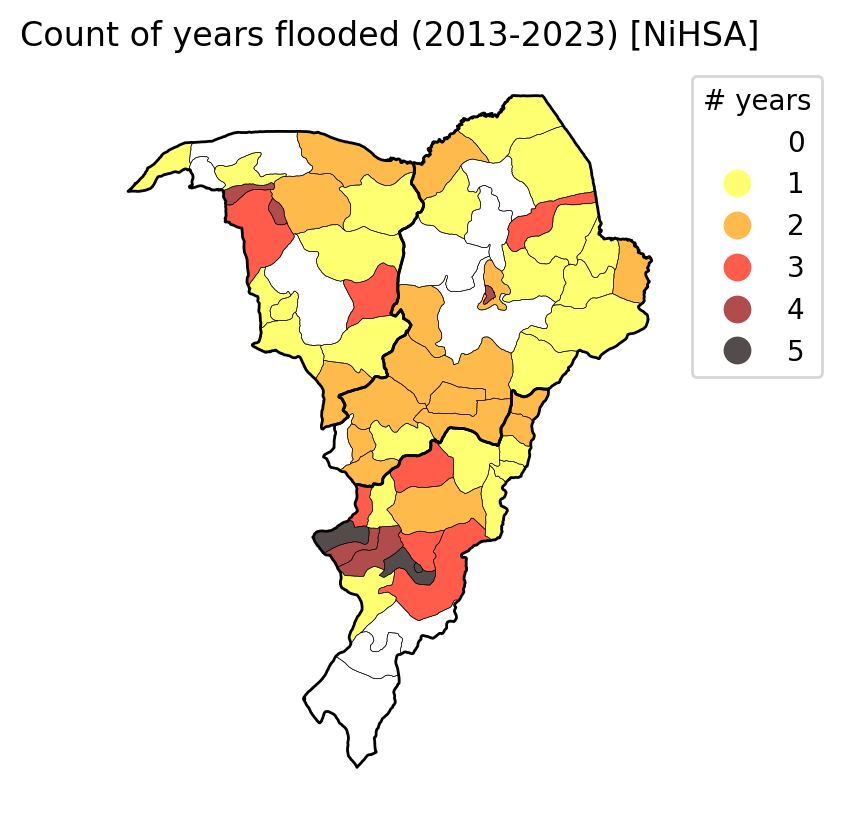

In [17]:
fig, ax = plt.subplots(dpi=200)

col = "Flooded"

gdf_plot = adm2.merge(df_nihsa_record_sum)
gdf_plot = gdf_plot[gdf_plot[col] >= 1]
gdf_plot[col] = (
    gdf_plot[col]
    .astype("category")
    .cat.add_categories([0])
    .cat.reorder_categories(range(6))
)
gdf_plot.plot(
    column=col,
    legend=True,
    ax=ax,
    cmap="hot_r",
    alpha=0.7,
    legend_kwds={
        "bbox_to_anchor": (1, 1),
        "loc": "upper left",
        "title": "# years",
    },
)

adm2.boundary.plot(ax=ax, linewidth=0.2, color="k")
adm1.boundary.plot(ax=ax, linewidth=1, color="k")

ax.axis("off")
ax.set_title("Count of years flooded (2013-2023) [NiHSA]")

In [18]:
df_nihsa_record_sum.merge(
    adm2[["ADM2_PCODE", "ADM2_EN", "ADM1_EN"]]
).sort_values(["Flooded", "ADM1_EN", "ADM2_EN"], ascending=False).iloc[
    :20
].drop(
    columns="ADM2_PCODE"
).rename(
    columns={"ADM2_EN": "LGA", "ADM1_EN": "State", "Flooded": "# years"}
)[
    ["State", "LGA", "# years"]
]

,State,LGA,# years
20,Adamawa,Yola South,5
19,Adamawa,Yola North,5
8,Adamawa,Lamurde,5
48,Yobe,Bade,4
41,Borno,Maiduguri,4
15,Adamawa,Numan,4
0,Adamawa,Demsa,4
56,Yobe,Jakusko,3
50,Yobe,Damaturu,3
44,Borno,Monguno,3


### NEMA flood risk

In [19]:
import src.constants

blob_name = f"{src.constants.PROJECT_PREFIX}/raw/AA-nigeria_data/NEMA/Flood Risk Excel Data 2.xlsx"
df_nema_risk = blob.load_excel_from_blob(blob_name)

In [20]:
df_nema_risk

,ADM2_EN,ADM2_PCODE,ADM1_EN,ADM1_PCODE,STATE,ADM2_PCODE2,Riverine Flood Risk,Flash Flood Risk,Coastal Flood Risk,Comments,Column3
0,Aba North,NG001001,Abia,NG001,Abia,NG001001,NaN,High,NaN,<Null>,NaN
1,Aba South,NG001002,Abia,NG001,Abia,NG001002,NaN,High,NaN,<Null>,NaN
2,Abadam,NG008001,Borno,NG008,Borno,NG008001,Low,Low,NaN,<Null>,NaN
3,Abaji,NG015001,Federal Capital Territory,NG015,Federal Capital Territory,NG015001,High,NaN,NaN,Nearness to River Niger,NaN
4,Abak,NG003001,Akwa Ibom,NG003,Akwa Ibom,NG003001,NaN,Low,NaN,<Null>,NaN
...,...,...,...,...,...,...,...,...,...,...,...
769,Zango-Kataf,NG019022,Kaduna,NG019,Kaduna,NG019022,NaN,NaN,NaN,<Null>,NaN
770,Zaria,NG019023,Kaduna,NG019,Kaduna,NG019023,NaN,Medium,NaN,"MUGUME, GYALLESU, WUCHICHRI",NaN
771,Zing,NG035016,Taraba,NG035,Taraba,NG035016,Low,NaN,NaN,<Null>,NaN
772,Zurmi,NG037014,Zamfara,NG037,Zamfara,NG037014,Medium,NaN,NaN,"Dole Moriki, Kwangwami,",NaN


In [21]:
df_nema_risk["riv_num"] = df_nema_risk["Riverine Flood Risk"].replace(
    {"Very High": 4, "High": 3, "Medium": 2, "Low": 1}
)
df_nema_risk["flash_num"] = df_nema_risk["Flash Flood Risk"].replace(
    {"Very High": 4, "High": 3, "Medium": 2, "Low": 1}
)

/var/folders/66/764yc5p92nvdc_nm3xmy5rn40000gn/T/ipykernel_27535/1711243050.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_nema_risk["riv_num"] = df_nema_risk["Riverine Flood Risk"].replace(
/var/folders/66/764yc5p92nvdc_nm3xmy5rn40000gn/T/ipykernel_27535/1711243050.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_nema_risk["flash_num"] = df_nema_risk["Flash Flood Risk"].replace(


Text(0.5, 1.0, 'Riverine Flood Risk [NEMA]')

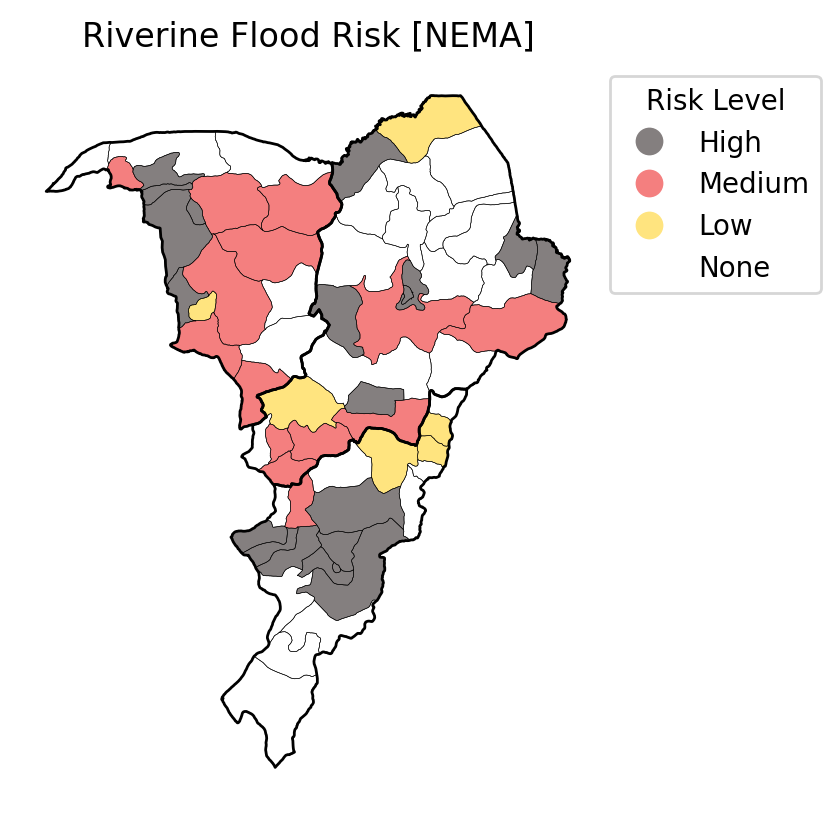

In [22]:
fig, ax = plt.subplots(dpi=200)

col = "Riverine Flood Risk"

gdf_plot = adm2.merge(df_nema_risk)
gdf_plot[col] = (
    gdf_plot[col]
    .astype("category")
    .cat.reorder_categories(["High", "Medium", "Low"])
    .cat.add_categories(["None"])
)

gdf_plot.plot(
    column=col,
    legend=True,
    ax=ax,
    cmap="hot",
    alpha=0.5,
    legend_kwds={
        "bbox_to_anchor": (1, 1),
        "loc": "upper left",
        "title": "Risk Level",
    },
)

adm2.boundary.plot(ax=ax, linewidth=0.2, color="k")
adm1.boundary.plot(ax=ax, linewidth=1, color="k")

ax.axis("off")
ax.set_title(f"{col} [NEMA]")

Text(0.5, 1.0, 'Flash Flood Risk [NEMA]')

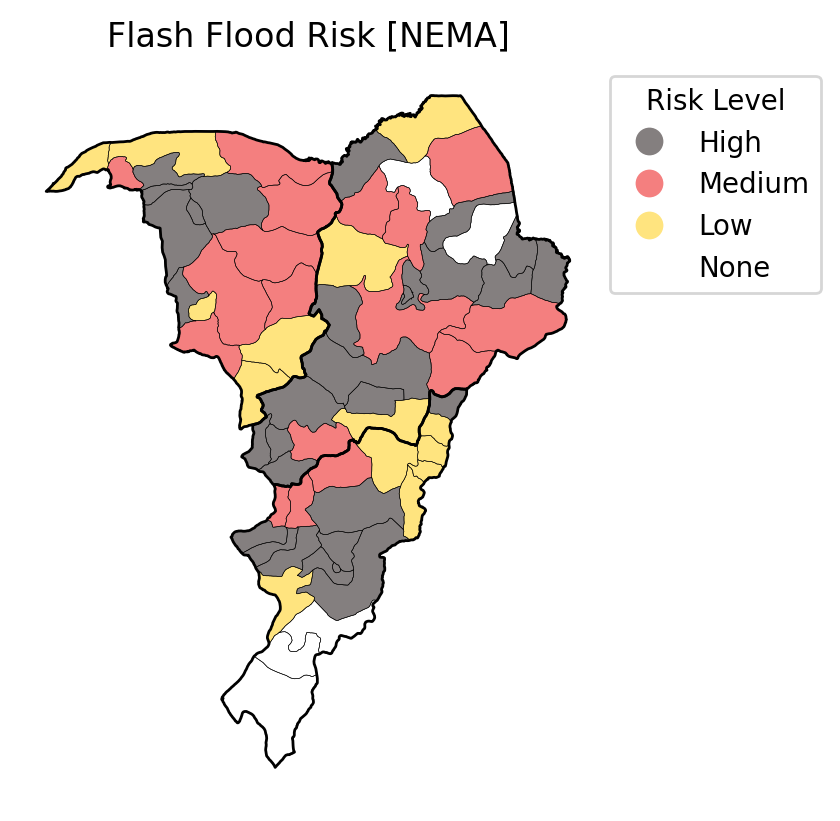

In [23]:
fig, ax = plt.subplots(dpi=200)

col = "Flash Flood Risk"

gdf_plot = adm2.merge(df_nema_risk)
gdf_plot[col] = (
    gdf_plot[col]
    .astype("category")
    .cat.reorder_categories(["High", "Medium", "Low"])
    .cat.add_categories(["None"])
)

gdf_plot.plot(
    column=col,
    legend=True,
    ax=ax,
    alpha=0.5,
    cmap="hot",
    legend_kwds={
        "bbox_to_anchor": (1, 1),
        "loc": "upper left",
        "title": "Risk Level",
    },
)

adm2.boundary.plot(ax=ax, linewidth=0.2, color="k")
adm1.boundary.plot(ax=ax, linewidth=1, color="k")

ax.axis("off")
ax.set_title(f"{col} [NEMA]")

In [24]:
df_nema_risk["riv_num"].unique()

array([nan,  1.,  3.,  2.,  4.])

In [25]:
df_nema_risk["flash_num"].unique()

array([ 3.,  1., nan,  2.,  4.])

In [26]:
df_nema_risk[
    (
        df_nema_risk["riv_num"].astype(float)
        + df_nema_risk["flash_num"].astype(float)
        == 6
    )
    & (df_nema_risk["ADM1_PCODE"].isin(AOI_ADM1_PCODES))
][["STATE", "ADM2_EN"]].sort_values(["STATE", "ADM2_EN"]).rename(
    columns={"ADM2_EN": "LGA"}
)

,STATE,LGA
158,Adamawa,Demsa
222,Adamawa,Fufore
243,Adamawa,Girei
462,Adamawa,Lamurde
541,Adamawa,Numan
686,Adamawa,Song
762,Adamawa,Yola North
763,Adamawa,Yola South
139,Borno,Chibok
387,Borno,Jere


### Floodscan exposure

In [27]:
fs = floodscan.load_adm2_flood_exposures()
fs_mean = fs.groupby("ADM2_PCODE")["total_exposed"].mean().reset_index()

Text(0.5, 1.0, 'Floodscan mean historical exposure (1998-2023)')

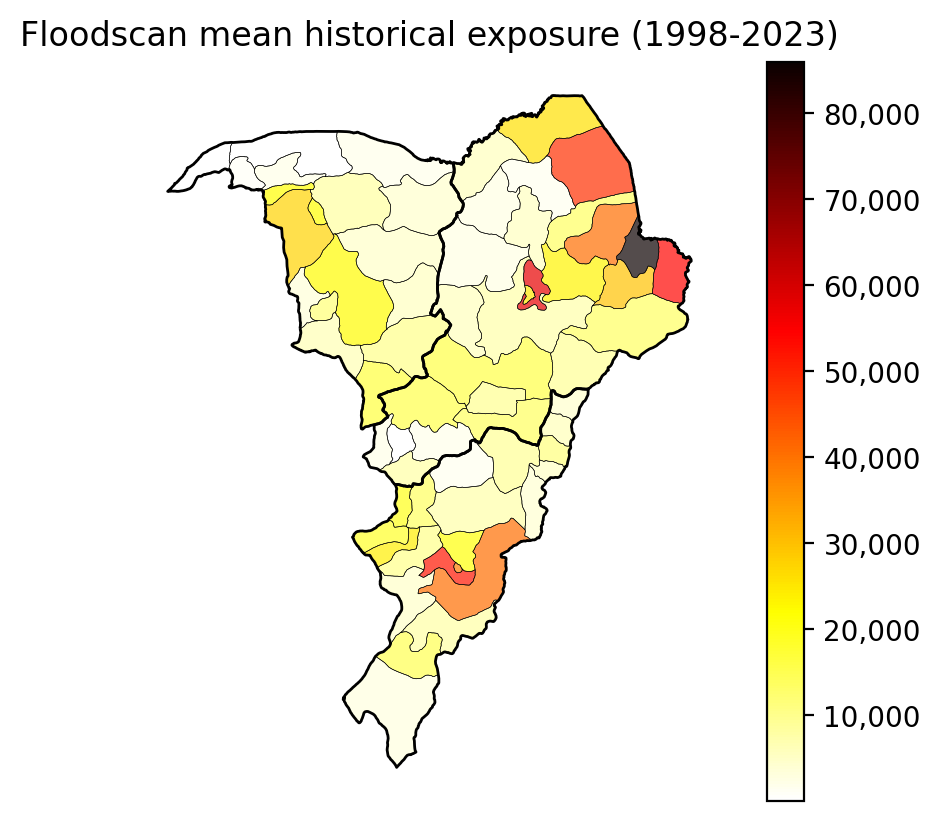

In [28]:
fig, ax = plt.subplots(dpi=200)

adm2.merge(fs_mean).plot(
    column="total_exposed", legend=True, ax=ax, alpha=0.7, cmap="hot_r"
)
cbar = ax.get_figure().axes[-1]  # Get last axis (colorbar)
cbar.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x:,.0f}"))

adm2.boundary.plot(ax=ax, linewidth=0.2, color="k")
adm1.boundary.plot(ax=ax, linewidth=1, color="k")

ax.axis("off")
ax.set_title("Floodscan mean historical exposure (1998-2023)")

In [83]:
fs_mean.merge(adm2[["ADM2_PCODE", "ADM2_EN", "ADM1_EN"]]).rename(
    columns={
        "ADM2_EN": "LGA",
        "ADM1_EN": "State",
        "total_exposed": "Total Exposed",
    }
)[["State", "LGA", "Total Exposed"]].sort_values(
    "Total Exposed", ascending=False
).astype(
    int, errors="ignore"
).iloc[
    :20
].style.background_gradient(
    subset=["Total Exposed"], cmap="hot_r", vmin=0
).format(
    {"Total Exposed": "{:,}"}
)

,State,LGA,Total Exposed
45,Borno,Ngala,"85,934"
33,Borno,Jere,"57,577"
35,Borno,Kala/Balge,"53,787"
20,Adamawa,Yola South,"51,940"
37,Borno,Kukawa,"48,488"
1,Adamawa,Fufore,"40,547"
42,Borno,Marte,"40,393"
19,Adamawa,Yola North,"38,587"
28,Borno,Dikwa,"29,676"
56,Yobe,Jakusko,"27,343"


### NEMA UNICEF impact

In [30]:
import src.constants

blob_name = f"{src.constants.PROJECT_PREFIX}/processed/nema/NEMA Copy of FLOOD DISASTER _DATA processed.csv"
df_unicef = blob.load_csv_from_blob(blob_name)
df_unicef = (
    df_unicef.melt(id_vars=[x for x in df_unicef.columns if "ADM" in x])
    .drop(columns="variable")
    .rename(columns={"value": "year"})
)
df_unicef = df_unicef.dropna()
df_unicef["year"] = df_unicef["year"].astype(int)

In [31]:
df_unicef_count = (
    df_unicef.groupby("ADM2_PCODE")
    .size()
    .reset_index()
    .rename(columns={0: "count_floods"})
)

In [32]:
df_unicef_unique_count = (
    df_unicef.groupby("ADM2_PCODE")["year"]
    .nunique()
    .reset_index()
    .rename(columns={"year": "count_years"})
)

In [33]:
df_unicef_count = df_unicef_count.merge(df_unicef_unique_count)

In [34]:
df_unicef_count

,ADM2_PCODE,count_floods,count_years
0,NG002001,4,3
1,NG002002,5,3
2,NG002003,2,1
3,NG002004,1,1
4,NG002005,3,2
5,NG002006,3,2
6,NG002009,1,1
7,NG002010,5,4
8,NG002012,2,1
9,NG002016,4,3


Text(0.5, 1.0, 'Count of years flooded (2013-2023) [UNICEF]')

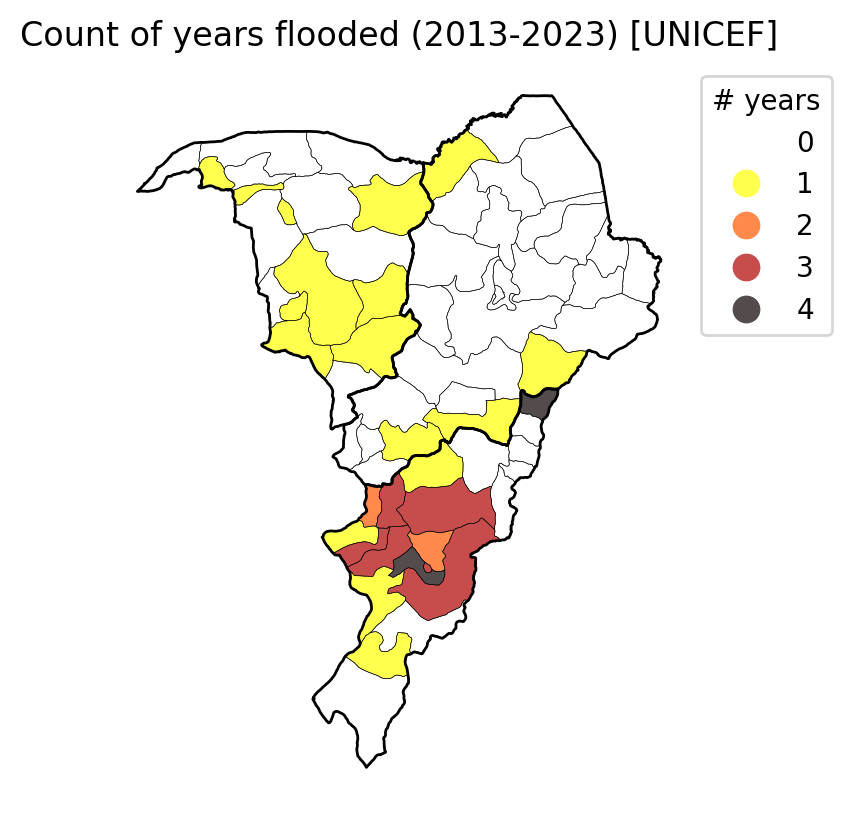

In [35]:
fig, ax = plt.subplots(dpi=200)

col = "count_years"

gdf_plot = adm2.merge(df_unicef_count)
gdf_plot[col] = (
    gdf_plot[col]
    .astype("category")
    .cat.add_categories([0])
    .cat.reorder_categories(range(5))
)
gdf_plot.plot(
    column=col,
    legend=True,
    ax=ax,
    cmap="hot_r",
    alpha=0.7,
    legend_kwds={
        "bbox_to_anchor": (1, 1),
        "loc": "upper left",
        "title": "# years",
    },
)

adm2.boundary.plot(ax=ax, linewidth=0.2, color="k")
adm1.boundary.plot(ax=ax, linewidth=1, color="k")

ax.axis("off")
ax.set_title("Count of years flooded (2013-2023) [UNICEF]")

Text(0.5, 1.0, 'Count of flood reports (2013-2023) [UNICEF]')

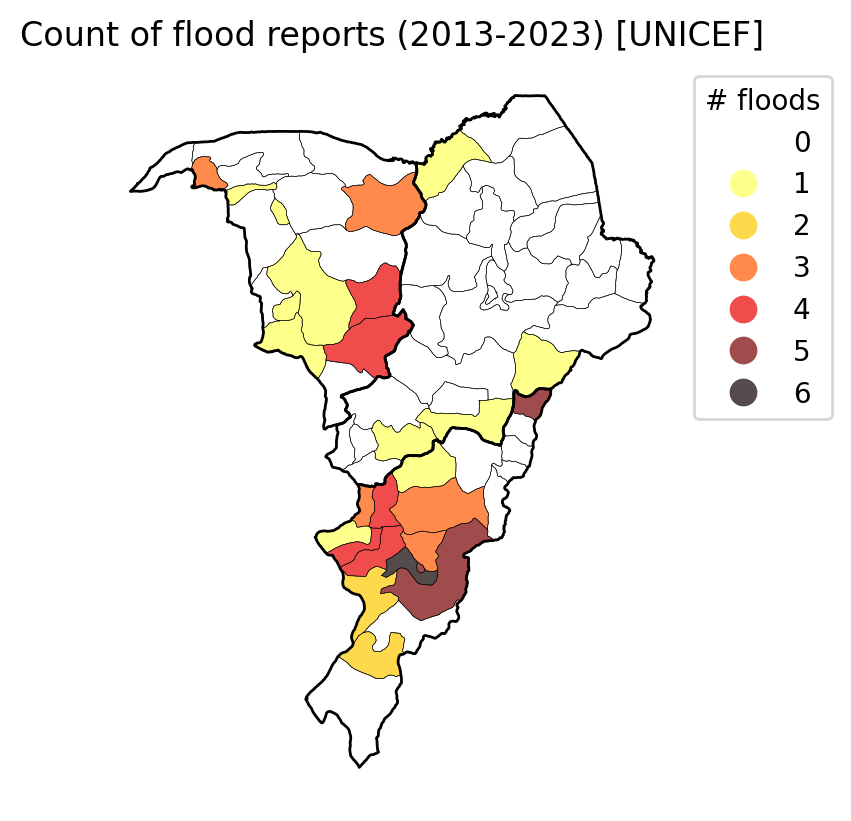

In [36]:
fig, ax = plt.subplots(dpi=200)

col = "count_floods"

gdf_plot = adm2.merge(df_unicef_count)
gdf_plot[col] = (
    gdf_plot[col]
    .astype("category")
    .cat.add_categories([0])
    .cat.reorder_categories(range(7))
)
gdf_plot.plot(
    column=col,
    legend=True,
    ax=ax,
    cmap="hot_r",
    alpha=0.7,
    legend_kwds={
        "bbox_to_anchor": (1, 1),
        "loc": "upper left",
        "title": "# floods",
    },
)

adm2.boundary.plot(ax=ax, linewidth=0.2, color="k")
adm1.boundary.plot(ax=ax, linewidth=1, color="k")

ax.axis("off")
ax.set_title("Count of flood reports (2013-2023) [UNICEF]")

In [37]:
df_unicef_count[df_unicef_count["count_floods"] >= 4].merge(
    adm2[["ADM2_PCODE", "ADM2_EN", "ADM1_EN"]]
).sort_values(["ADM1_EN", "ADM2_EN"]).sort_values(
    "count_floods", ascending=False
).rename(
    columns={"ADM2_EN": "LGA", "ADM1_EN": "State"}
)[
    ["State", "LGA", "count_floods"]
]

,State,LGA,count_floods
6,Adamawa,Yola South,6
1,Adamawa,Fufore,5
2,Adamawa,Madagali,5
5,Adamawa,Yola North,5
0,Adamawa,Demsa,4
3,Adamawa,Numan,4
4,Adamawa,Shelleng,4
7,Yobe,Damaturu,4
8,Yobe,Gujba,4


### IOM rain season impact

In [38]:
import src.constants

blob_name = f"{src.constants.PROJECT_PREFIX}/processed/iom/rainseason_2021_2024.parquet"
df_iom = blob.load_parquet_from_blob(blob_name)

In [39]:
df_iom_sum = df_iom.groupby("ADM2_PCODE")["#HH Affected"].sum().reset_index()

Text(0.5, 1.0, 'Number of households affected (2021-2024) [IOM]')

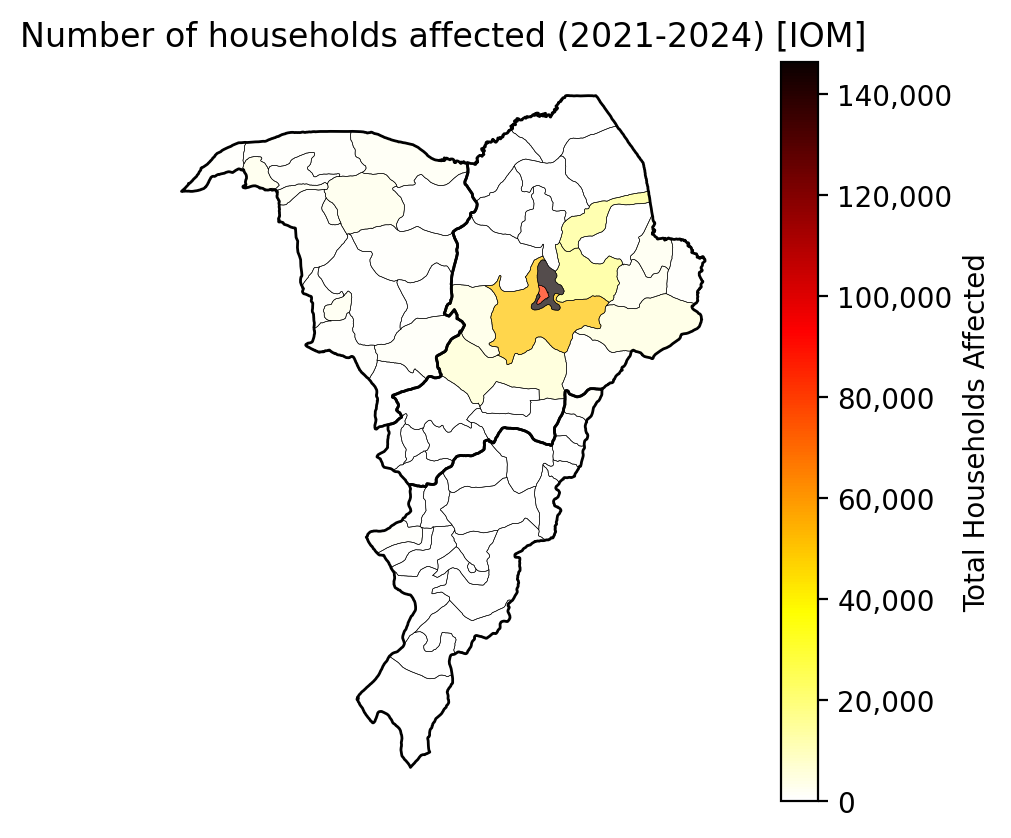

In [40]:
fig, ax = plt.subplots(dpi=200)

col = "#HH Affected"

gdf_plot = adm2.merge(df_iom_sum)

gdf_plot.plot(
    column=col,
    legend=True,
    ax=ax,
    alpha=0.7,
    cmap="hot_r",
    legend_kwds={"label": "Total Households Affected"},
)
cbar = ax.get_figure().axes[-1]  # Get last axis (colorbar)
cbar.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x:,.0f}"))


adm2.boundary.plot(ax=ax, linewidth=0.2, color="k")
adm1.boundary.plot(ax=ax, linewidth=1, color="k")

ax.axis("off")
ax.set_title("Number of households affected (2021-2024) [IOM]")

In [41]:
gdf_plot.sort_values(col, ascending=False)[["ADM1_EN", "ADM2_EN", col]]

,ADM1_EN,ADM2_EN,#HH Affected
18,Borno,Jere,146400.0
28,Borno,Maiduguri,83229.0
22,Borno,Konduga,50224.0
26,Borno,Mafa,17257.0
30,Borno,Monguno,16107.0
6,Borno,Damboa,7298.0
1,Borno,Bama,5001.0
19,Borno,Kaga,4299.0
34,Yobe,Nguru,2891.0
3,Yobe,Bursari,2865.0


In [42]:
df_iom_sum["#HH Affected"].quantile(0.9)

16107.0

## Comparison

In [43]:
df_combined = (
    adm2.merge(fs_mean, how="left")
    .merge(df_unicef_count, how="left")
    .merge(df_nema_risk, how="left")
    .merge(df_nihsa_record_sum, how="left")
    .merge(df_iom_sum, how="left")
)
df_combined

,ADM2_EN,ADM2_PCODE,ADM1_EN,ADM1_PCODE,ADM0_EN,ADM0_PCODE,DATE,VALIDON,VALIDTO,geometry,...,ADM2_PCODE2,Riverine Flood Risk,Flash Flood Risk,Coastal Flood Risk,Comments,Column3,riv_num,flash_num,Flooded,#HH Affected
0,Abadam,NG008001,Borno,NG008,Nigeria,NG,2017-03-31,2019-04-17,NaT,"POLYGON ((13.11029 13.10963, 13.10815 13.11404...",...,NG008001,Low,Low,NaN,<Null>,NaN,1.0,1.0,1,NaN
1,Askira/Uba,NG008002,Borno,NG008,Nigeria,NG,2017-03-31,2019-04-17,NaT,"POLYGON ((13.09852 10.44508, 13.09352 10.44667...",...,NG008002,Medium,Low,NaN,<Null>,NaN,2.0,1.0,2,NaN
2,Bade,NG036001,Yobe,NG036,Nigeria,NG,2017-03-31,2019-04-17,NaT,"MULTIPOLYGON (((11.18769 12.50815, 11.1836 12....",...,NG036001,High,High,NaN,PREVALENCE OF RIVERINE FLOOD IS MORE,NaN,3.0,3.0,4,1720.0
3,Bama,NG008003,Borno,NG008,Nigeria,NG,2017-03-31,2019-04-17,NaT,"POLYGON ((13.99056 11.31251, 13.97581 11.30513...",...,NG008003,Medium,Medium,NaN,<Null>,NaN,2.0,2.0,1,5001.0
4,Bayo,NG008004,Borno,NG008,Nigeria,NG,2017-03-31,2019-04-17,NaT,"POLYGON ((11.65688 10.19681, 11.60128 10.20806...",...,NG008004,NaN,High,NaN,<Null>,NaN,NaN,3.0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,Toungo,NG002019,Adamawa,NG002,Nigeria,NG,2017-03-31,2019-04-17,NaT,"POLYGON ((12.21046 7.97042, 12.203 7.96432, 12...",...,NG002019,NaN,NaN,NaN,<Null>,NaN,NaN,NaN,0,NaN
61,Yola North,NG002020,Adamawa,NG002,Nigeria,NG,2017-03-31,2019-04-17,NaT,"POLYGON ((12.40447 9.25767, 12.40226 9.26307, ...",...,NG002020,High,High,NaN,<Null>,NaN,3.0,3.0,5,NaN
62,Yola South,NG002021,Adamawa,NG002,Nigeria,NG,2017-03-31,2019-04-17,NaT,"POLYGON ((12.43708 9.213, 12.43732 9.21285, 12...",...,NG002021,High,High,NaN,<Null>,NaN,3.0,3.0,5,29.0
63,Yunusari,NG036016,Yobe,NG036,Nigeria,NG,2017-03-31,2019-04-17,NaT,"POLYGON ((12.13949 13.09935, 12.14254 13.09896...",...,NG036016,NaN,Medium,NaN,<Null>,NaN,NaN,2.0,2,1973.0


In [45]:
benue = hydrosheds.load_benue_aoi()

Text(0.5, 1.0, 'Mean historical flood exposure in filtered areas\n(riverine flood focus)')

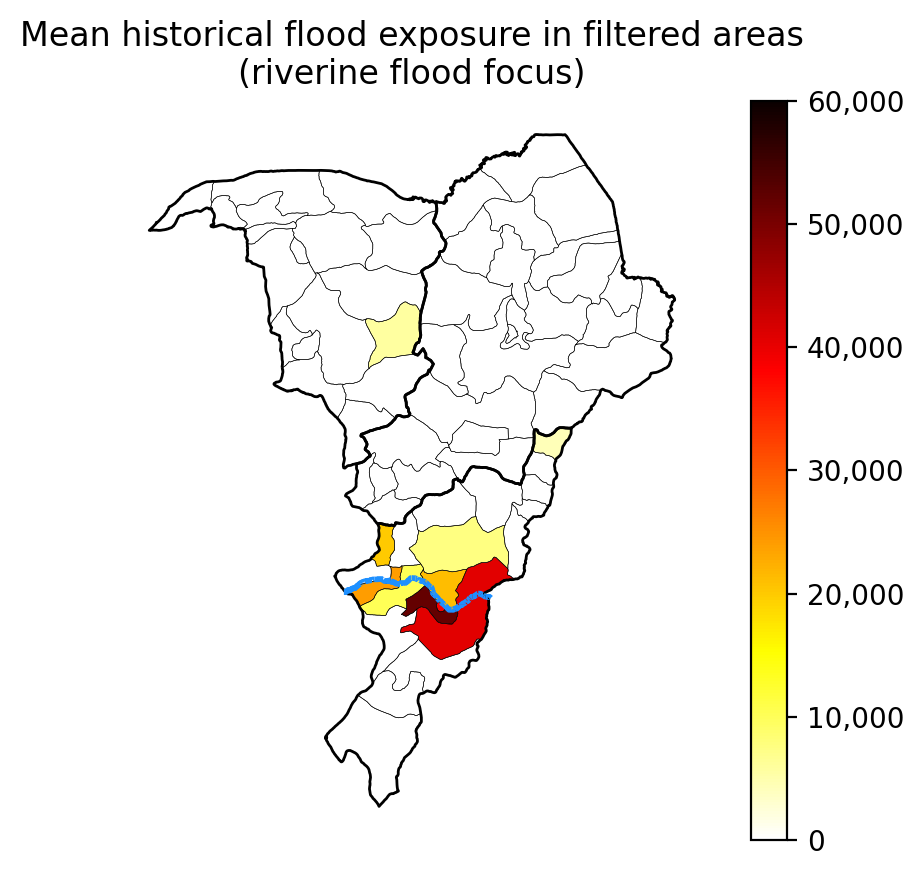

In [89]:
gdf_plot = df_combined[
    (df_combined["count_floods"] >= 3)
    & ((df_combined["riv_num"] >= 2) | (df_combined["flash_num"] >= 2))
    & (df_combined["Flooded"] >= 2)
].copy()

fig, ax = plt.subplots(dpi=200)

col = "total_exposed"


gdf_plot.plot(column=col, legend=True, ax=ax, cmap="hot_r", vmin=0, vmax=60000)
cbar = ax.get_figure().axes[-1]  # Get last axis (colorbar)
cbar.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x:,.0f}"))


adm2.boundary.plot(ax=ax, linewidth=0.2, color="k")
adm1.boundary.plot(ax=ax, linewidth=1, color="k")
benue.plot(ax=ax, color="dodgerblue", linewidth=2)

ax.axis("off")
ax.set_title(
    "Mean historical flood exposure in filtered areas\n(riverine flood focus)"
)

In [91]:
gdf_plot["Total Exposed"] = gdf_plot["total_exposed"].astype(int)
gdf_plot.sort_values("Total Exposed", ascending=False)[
    ["ADM1_EN", "ADM2_EN", "Total Exposed"]
].rename(
    columns={"ADM2_EN": "LGA", "ADM1_EN": "State"}
).style.background_gradient(
    subset=["Total Exposed"], cmap="hot_r", vmin=0
).format(
    {"Total Exposed": "{:,}"}
)

,State,LGA,Total Exposed
62,Adamawa,Yola South,"51,940"
13,Adamawa,Fufore,"40,547"
61,Adamawa,Yola North,"38,587"
54,Adamawa,Numan,"23,965"
17,Adamawa,Girei,"21,222"
22,Adamawa,Guyuk,"20,071"
10,Adamawa,Demsa,"10,107"
58,Adamawa,Song,"7,535"
8,Yobe,Damaturu,"5,683"
38,Adamawa,Madagali,"4,449"


In [49]:
df_combined[
    (df_combined["#HH Affected"] >= 5000)
    & ((df_combined["riv_num"] >= 2) | (df_combined["flash_num"] >= 2))
    # & (df_combined["Flooded"] >= 2)
]

,ADM2_EN,ADM2_PCODE,ADM1_EN,ADM1_PCODE,ADM0_EN,ADM0_PCODE,DATE,VALIDON,VALIDTO,geometry,...,ADM2_PCODE2,Riverine Flood Risk,Flash Flood Risk,Coastal Flood Risk,Comments,Column3,riv_num,flash_num,Flooded,#HH Affected
3,Bama,NG008003,Borno,NG008,Nigeria,NG,2017-03-31,2019-04-17,NaT,"POLYGON ((13.99056 11.31251, 13.97581 11.30513...",...,NG008003,Medium,Medium,NaN,<Null>,NaN,2.0,2.0,1,5001.0
9,Damboa,NG008007,Borno,NG008,Nigeria,NG,2017-03-31,2019-04-17,NaT,"POLYGON ((12.90696 11.27313, 12.91443 11.27299...",...,NG008007,NaN,High,NaN,<Null>,NaN,NaN,3.0,2,7298.0
29,Jere,NG008013,Borno,NG008,Nigeria,NG,2017-03-31,2019-04-17,NaT,"POLYGON ((13.11072 11.76419, 13.11178 11.76555...",...,NG008013,High,High,NaN,regular realease of water from Labdo Dam in ca...,NaN,3.0,3.0,2,146400.0
33,Konduga,NG008016,Borno,NG008,Nigeria,NG,2017-03-31,2019-04-17,NaT,"POLYGON ((12.7054 11.29421, 12.70365 11.29971,...",...,NG008016,Medium,Medium,NaN,<Null>,NaN,2.0,2.0,0,50224.0
39,Mafa,NG008019,Borno,NG008,Nigeria,NG,2017-03-31,2019-04-17,NaT,"POLYGON ((13.29473 11.76548, 13.29185 11.76604...",...,NG008019,NaN,High,NaN,<Null>,NaN,NaN,3.0,1,17257.0
41,Maiduguri,NG008021,Borno,NG008,Nigeria,NG,2017-03-31,2019-04-17,NaT,"POLYGON ((13.06877 11.74765, 13.06564 11.75216...",...,NG008021,High,High,NaN,regular realease of water from Labdo Dam in ca...,NaN,3.0,3.0,4,83229.0
47,Monguno,NG008024,Borno,NG008,Nigeria,NG,2017-03-31,2019-04-17,NaT,"POLYGON ((13.46501 12.2811, 13.46621 12.27732,...",...,NG008024,NaN,High,NaN,<Null>,NaN,NaN,3.0,3,16107.0


Text(0.5, 1.0, 'Mean historical flood exposure in filtered areas\n(flash flood focus)')

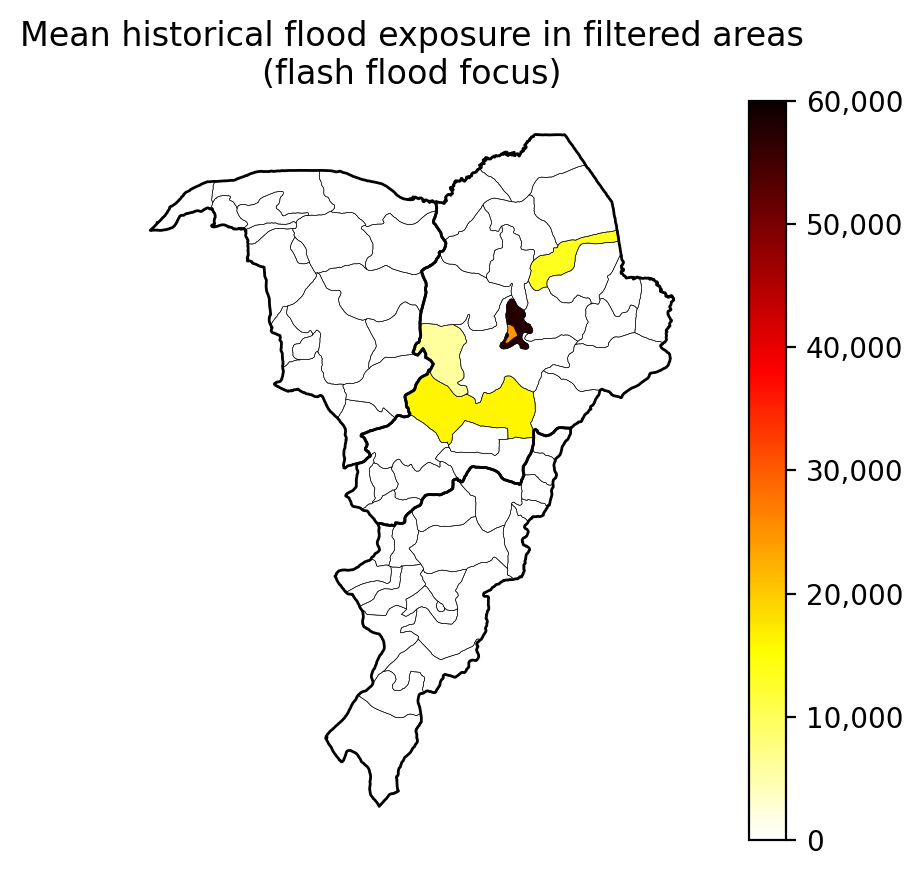

In [87]:
gdf_plot = df_combined[
    (df_combined["#HH Affected"] >= df_combined["#HH Affected"].quantile(0.8))
    & ((df_combined["riv_num"] >= 2) | (df_combined["flash_num"] >= 2))
    & (df_combined["Flooded"] >= 2)
].copy()

fig, ax = plt.subplots(dpi=200)

col = "total_exposed"


gdf_plot.plot(column=col, legend=True, ax=ax, cmap="hot_r", vmin=0, vmax=60000)
cbar = ax.get_figure().axes[-1]  # Get last axis (colorbar)
cbar.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x:,.0f}"))


adm2.boundary.plot(ax=ax, linewidth=0.2, color="k")
adm1.boundary.plot(ax=ax, linewidth=1, color="k")

ax.axis("off")
ax.set_title(
    "Mean historical flood exposure in filtered areas\n(flash flood focus)"
)

In [88]:
gdf_plot["Total Exposed"] = gdf_plot["total_exposed"].astype(int)
gdf_plot.sort_values("Total Exposed", ascending=False)[
    ["ADM1_EN", "ADM2_EN", "Total Exposed"]
].rename(
    columns={"ADM2_EN": "LGA", "ADM1_EN": "State"}
).style.background_gradient(
    subset=["Total Exposed"], cmap="hot_r", vmin=0
).format(
    {"Total Exposed": "{:,}"}
)

,State,LGA,Total Exposed
29,Borno,Jere,"57,577"
41,Borno,Maiduguri,"24,525"
9,Borno,Damboa,"15,960"
47,Borno,Monguno,"13,565"
30,Borno,Kaga,"5,875"
